In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, lower, split, when,count, when, lit, unix_timestamp, to_date
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import avg

In [40]:
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz

In [ ]:
# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz

In [2]:
!pip install textblob
!pip install pyspark nltk
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Data Reading

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 24) \
    .config("spark.sql.shuffle.partitions", 24) \
    .getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/03 13:23:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

# Show the DataFrame to check if it's loaded correctly
#df.show(10)

23/12/03 13:23:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
### load the meta data

df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")
#df_meta.show(10)

# EDA and Data Pre-Processing

In [8]:
# summarize the nulls in dataframe
# Create an expression for each column that counts its nulls
exprs = [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]

# Compute all null counts in a single pass
null_counts = df.agg(*exprs).first().asDict()

# Get the total count of rows for percentage calculation
total_count = df.count()

# Iterate through the results and calculate percentages
for column, null_count in null_counts.items():
    null_percentage = (null_count / total_count) * 100
    print(f"Number of Nulls in {column}: {null_count}, Percentage: {null_percentage:.2f}%")


Number of Nulls in asin: 0, Percentage: 0.00%
Number of Nulls in image: 1725623, Percentage: 98.14%
Number of Nulls in overall: 0, Percentage: 0.00%
Number of Nulls in reviewText: 984, Percentage: 0.06%
Number of Nulls in reviewTime: 0, Percentage: 0.00%
Number of Nulls in reviewerID: 0, Percentage: 0.00%
Number of Nulls in reviewerName: 110, Percentage: 0.01%
Number of Nulls in style: 1066819, Percentage: 60.67%
Number of Nulls in summary: 403, Percentage: 0.02%
Number of Nulls in unixReviewTime: 0, Percentage: 0.00%
Number of Nulls in verified: 0, Percentage: 0.00%
Number of Nulls in vote: 1552025, Percentage: 88.27%


In [9]:
total_count

1758333

In [4]:
# Drop the image, style, vote columns
df = df.drop('image', 'style', 'vote')

In [5]:
# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [6]:
# Sample a fraction of the data (5%)
fraction = 0.05
seed = 42  # You can choose any number for the seed
df = df.sample(False, fraction, seed)

In [13]:
min_length, max_length = df.selectExpr("min(reviewText_length)", "max(reviewText_length)").first()

df.count()

81986

In [14]:
min_length,max_length

(1, 12541)

In [7]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold
df = df.filter(col('reviewText_length') < 1000)  # Example threshold

In [16]:
df.count()

75582

In [17]:
# Find the range for 'reviewText_length'
min_length, max_length = df.selectExpr("min(reviewText_length)", "max(reviewText_length)").first()

min_length,max_length

(11, 999)

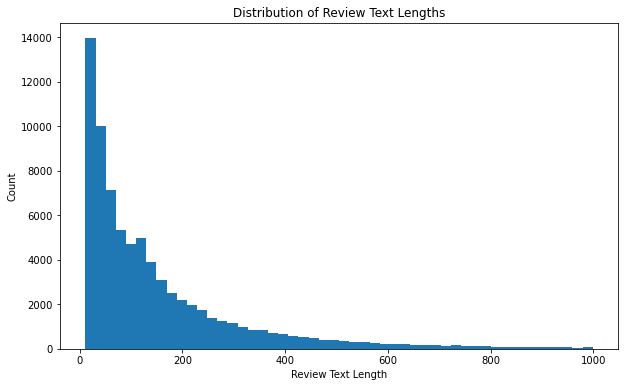

In [18]:
# Number of bins for the histogram
num_bins = 50

# Compute the bin size
bin_size = (max_length - min_length) / num_bins

# Create bins and count the number of records in each bin
bins_expr = [
    ((col('reviewText_length') - min_length) / bin_size).cast('integer').alias('bin')
]
histogram_df = df.select(*bins_expr).groupBy('bin').count()

# Collect the histogram data
histogram_data = histogram_df.sort('bin').collect()

# Prepare data for plotting
bins = [min_length + bin_size * i for i in range(num_bins + 1)]
counts = [0] * num_bins
for row in histogram_data:
    counts[row['bin']] = row['count']

plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()


## Text Processing

In [19]:
# # Text Processing - cleaning the review text, undercase the words, tokenizing, and removing stop words (simplified example)
# from pyspark.ml.feature import Tokenizer, StopWordsRemover
# from pyspark.sql.functions import udf
# from pyspark.sql.types import StringType, FloatType
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textblob import TextBlob
# import nltk
# nltk.download('vader_lexicon')

# # Define a UDF for sentiment analysis
# def get_sentiment(text):
#     analysis = TextBlob(str(text))
#     # Classify the polarity of the text
#     # You can customize this based on your needs
#     if analysis.sentiment.polarity > 0:
#         return "positive"
#     elif analysis.sentiment.polarity == 0:
#         return "neutral"
#     else:
#         return "negative"
    
# def analyze_sentiment(review_text):
#     sid = SentimentIntensityAnalyzer()
#     sentiment_score = sid.polarity_scores(review_text)['compound']
#     return sentiment_score

# sentiment_analysis_udf = udf(analyze_sentiment, FloatType())
# df = df.withColumn("sentiment_score", sentiment_analysis_udf(df["reviewText"]))

# # Register the UDF
# sentiment_udf = udf(get_sentiment, StringType())

# # Apply sentiment analysis to the 'reviewText' column
# df = df.withColumn("sentiment", sentiment_udf("reviewText"))


# df = df.withColumn('reviewText', lower(col('reviewText'))) 
# tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
# df = tokenizer.transform(df)
# remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
# df = remover.transform(df)

In [20]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.sql.functions import lower, col
import nltk

# Ensure required NLTK resources are downloaded
nltk.download('vader_lexicon')

# Text Preprocessing Pipeline
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
preprocessing_pipeline = Pipeline(stages=[tokenizer, remover])

# Transform DataFrame
df = df.withColumn('reviewText', lower(col('reviewText')))
df = preprocessing_pipeline.fit(df).transform(df)

# Define and register UDF for sentiment analysis (batch processing not shown here)
# Batch processing would require a more complex setup, possibly using Pandas UDFs
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def analyze_sentiment(review_text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(review_text)['compound']

sentiment_analysis_udf = udf(analyze_sentiment, FloatType())
df = df.withColumn("sentiment_score", sentiment_analysis_udf(df["reviewText"]))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ynx9zm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

# Data Visulization

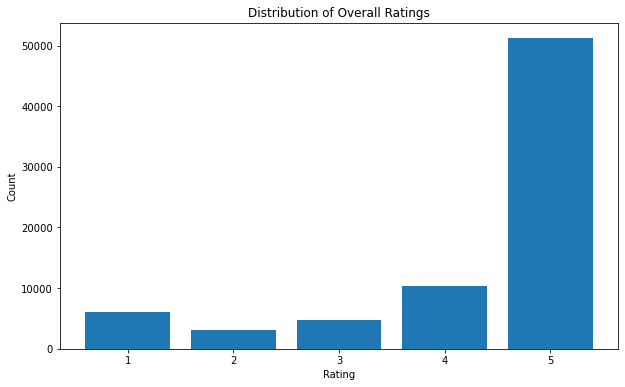

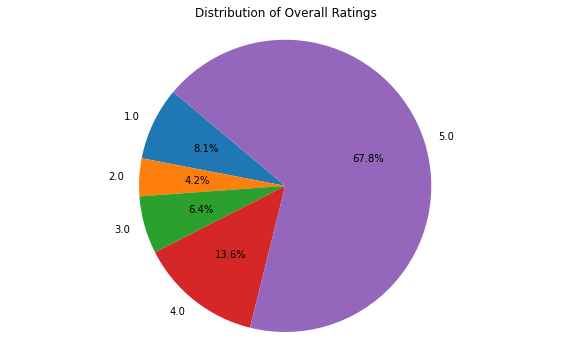

In [22]:


# Average rating (no change needed here)
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin (no change needed here)
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

# Count of reviews for each reviewer (no change needed here)
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

# Histogram for overall ratings - Compute in PySpark
overall_rating_distribution = df.groupBy("overall").count().orderBy("overall").collect()

# Convert histogram data to Pandas DataFrame for plotting
pdf_histogram = pd.DataFrame(overall_rating_distribution, columns=['Rating', 'Count'])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(pdf_histogram['Rating'], pdf_histogram['Count'])
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Pie chart for overall ratings - Compute in PySpark
rating_counts = df.groupBy("overall").count().orderBy("overall").collect()

# Convert pie chart data to Pandas Series for plotting
pdf_pie = pd.Series({row['overall']: row['count'] for row in rating_counts})

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(pdf_pie, labels=pdf_pie.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')
plt.show()

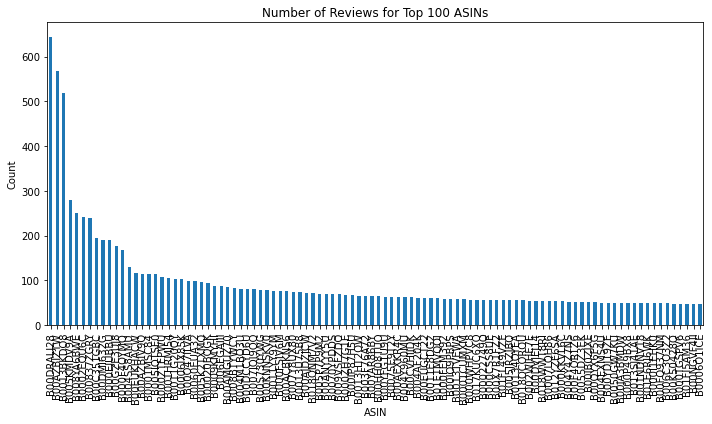

In [23]:
# Bar chart for number of reviews for each asin
# Sort and get top 100 ASINs in PySpark
top_reviews_per_asin = reviews_per_asin.orderBy(col("Number_of_Reviews").desc()).limit(100)

# Convert to Pandas DataFrame for plotting
top_reviews_per_asin_pdf = top_reviews_per_asin.toPandas()

# Plot bar chart using Pandas
plt.figure(figsize=(10, 6))
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

In [8]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [25]:
from pyspark.sql.functions import concat_ws, collect_list
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# # Sample a fraction of the data (5%)
# fraction = 0.01
# seed = 42  # You can choose any number for the seed
# sampled_df = df.sample(False, fraction, seed)

# Concatenate reviewText from all rows in the sampled PySpark DataFrame
review_text_str = df.select(concat_ws(" ", collect_list("reviewText"))).first()[0]

# Concatenate summary from all rows in the sampled PySpark DataFrame
summary_str = df.select(concat_ws(" ", collect_list("summary"))).first()[0]

# Generate word clouds
generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
plot = False

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd
if plot:
    # Define the number of bins for the histogram
    num_bins = 20

    # Calculate the range for sentiment scores
    min_score, max_score = df.selectExpr("min(sentiment_score)", "max(sentiment_score)").first()

    # Compute the bin size
    bin_size = (max_score - min_score) / num_bins

    # Create bins and count the number of records in each bin
    bins_expr = [
        ((col('sentiment_score') - min_score) / bin_size).cast('integer').alias('bin')
    ]
    histogram_df = df.select(*bins_expr).groupBy('bin').count()

    # Collect the histogram data
    histogram_data = histogram_df.sort('bin').collect()

    # Prepare data for plotting
    bins = [min_score + bin_size * i for i in range(num_bins + 1)]
    counts = [0] * num_bins
    for row in histogram_data:
        if 0 <= row['bin'] < num_bins:
            counts[row['bin']] = row['count']

    # Plotting using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.hist(bins[:-1], bins=bins, weights=counts)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Count')
    plt.grid(False)
    plt.show()

# Modelling

## Data Splitting

In [ ]:
###sampling
# sampled_df = df.sample(fraction=0.01, seed=42)
# sampled_df.count()

In [9]:
from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)

In [10]:
(train, test) = df.randomSplit([0.8, 0.2],seed = 42)

In [11]:
train = train.select("userIndex","itemIndex","overall")
test = test.select("userIndex","itemIndex","overall")


## ALS

refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark



In [12]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model; In this model set the cold start as drop
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

In [20]:
# Fit the ALS model to the training data
model = als.fit(train)

23/12/03 13:27:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:32 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [21]:
# # Fitting the ALS model on the training data
# model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)

23/12/03 13:27:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:51 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:28:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


In [22]:
model_path = "models/RatingALSModel_1.obj"
# Save the model, overwriting any existing model at the specified path
model.write().overwrite().save(model_path)

23/12/03 13:28:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers


23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/12/03 13:28:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/12/03 13:28:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
23/12/03 13:28:03 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.4

## For user who first appear in test set, recommend the most popular stuff to them.

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a Spark session
spark = SparkSession.builder.appName("PopularItemsRecommendation").getOrCreate()

# Find users in the test set that do not appear in the train set
newUsers = test.select("userIndex").subtract(train.select("userIndex")).distinct()

# Calculate item popularity based on the train set
itemPopularity = train.groupBy("itemIndex").agg(F.count("overall").alias("popularity"))

# Rank items based on popularity in descending order
rankedItems = itemPopularity.orderBy(F.desc("popularity"))

# Join the new users with the ranked items to recommend the most popular items
recommendations = newUsers.crossJoin(rankedItems.limit(10))  # Replace k with the number of items to recommend

# Select relevant columns for further processing or output
newRecommendations = recommendations.groupBy("userIndex").agg(F.collect_list("itemIndex").alias("name"))

In [14]:
newRecommendations.count()

23/12/03 13:25:50 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:25:50 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:26:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


14457

In [15]:
test.count()

23/12/03 13:26:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


15311

# grid search for ALS model

In [43]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10,30]) \
    .addGrid(als.maxIter, [5, 15]) \
    .addGrid(als.regParam, [0.01, 1.0]) \
    .build()


##cross validation
cross_val = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=reg_evaluator,
    numFolds=5)

In [17]:
retrain = False
if retrain:
    cv_model = cross_val.fit(train)
# best_model = cv_model.bestModel

# # Specify the path where you want to save the model
# model_path = "models/Best_RatingALSModel.obj"

# # Save the model, overwriting any existing model at the specified path
# best_model.write().overwrite().save(model_path)

In [49]:
rmse_train

0.003260037985302759

In [50]:
rmse_test

4.940007887749806

In [51]:
cv_model.avgMetrics

[4.950013332730643,
 4.603276629442055,
 4.806474429015735,
 4.582132936875243,
 4.610608182697979,
 4.522620926823878,
 4.565218829699182,
 4.505357481791878]

## Recall

In [18]:
from pyspark.ml.recommendation import ALSModel
recommendnum = 10
als_model = ALSModel.load("models/Best_RatingALSModel.obj")
als_model.recommendForAllUsers(recommendnum).show(1)

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|        3|[{3017, 4.086563}...|
+---------+--------------------+
only showing top 1 row



In [23]:
als_model0 = ALSModel.load("models/RatingALSModel_1.obj")
als_model0.recommendForAllUsers(recommendnum).show(1)

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|        3|[{1610, 20.023806...|
+---------+--------------------+
only showing top 1 row



In [24]:
df_temp = als_model.recommendForAllUsers(10) # Only on training set

In [25]:
df_temp0 = als_model0.recommendForAllUsers(10) # Only on training set

In [24]:
# x = df_temp.select('recommendations').collect()
# x0 = df_temp0.select('recommendations').collect()

In [26]:
df_temp.groupBy(col("userIndex")).count().count()

58708

In [92]:
df_temp0.orderBy(col("userIndex"))

587220

In [27]:
from pyspark.sql.functions import col,explode
df_temp = df_temp.withColumn("name", explode(col('recommendations')))

In [28]:
df_temp0 = df_temp0.withColumn("name", explode(col('recommendations')))

In [29]:
df_temp.show(10)

+---------+--------------------+------------------+
|userIndex|     recommendations|              name|
+---------+--------------------+------------------+
|        3|[{3017, 4.086563}...|  {3017, 4.086563}|
|        3|[{3017, 4.086563}...| {10471, 4.073551}|
|        3|[{3017, 4.086563}...|{19573, 4.0489764}|
|        3|[{3017, 4.086563}...|{22730, 3.8789766}|
|        3|[{3017, 4.086563}...|  {448, 3.8419113}|
|        3|[{3017, 4.086563}...|  {655, 3.7570543}|
|        3|[{3017, 4.086563}...|  {296, 3.7474897}|
|        3|[{3017, 4.086563}...|{26095, 3.4820004}|
|        3|[{3017, 4.086563}...| {2915, 3.3522973}|
|        3|[{3017, 4.086563}...|{15945, 3.1983292}|
+---------+--------------------+------------------+
only showing top 10 rows



In [31]:
from pyspark.sql.functions import col,expr
df_temp = df_temp.withColumn("name", expr("transform(recommendations, r -> r.itemIndex)"))
df_temp = df_temp.drop_duplicates()
df_temp0 = df_temp0.withColumn("name", expr("transform(recommendations, r -> r.itemIndex)"))
df_temp0 = df_temp0.drop_duplicates()

In [52]:
# Ensure the column order is the same in both DataFrames
df_temp = df_temp.select("userIndex", "name")
df_temp0 = df_temp0.select("userIndex", "name")

# Union the DataFrames
best_pred = df_temp.unionByName(newRecommendations)
base_pred = df_temp0.unionByName(newRecommendations)

In [33]:
from pyspark.sql.functions import collect_list
actualitem = test.groupby('userIndex').agg(collect_list('itemIndex').alias('indexlist')) # This should be test

In [34]:
actualitem.orderBy(col("userIndex")).show(10)

23/12/03 13:30:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:30:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
+---------+--------------------+
|userIndex|           indexlist|
+---------+--------------------+
|      0.0|   [7992.0, 19998.0]|
|      2.0|[4351.0, 17086.0,...|
|      3.0|      [296.0, 276.0]|
|      4.0|    [11723.0, 493.0]|
|      5.0|     [101.0, 1871.0]|
|      6.0|     [5001.0, 722.0]|
|      8.0|           [13923.0]|
|      9.0|           [14645.0]|
|     10.0|            [5159.0]|
|     12.0|            [7699.0]|
+---------+--------------------+
only showing top 10 rows



In [35]:
actualitem.count()-newRecommendations.count()

23/12/03 13:30:57 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


734

In [36]:
result = df_temp.join(actualitem, 'userIndex')

In [37]:
result.count()

23/12/03 13:31:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


734

In [38]:
result0 = df_temp0.join(actualitem, 'userIndex')

In [39]:
result0.count()

23/12/03 13:31:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:31:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:31:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


734

In [53]:
result_best = best_pred.join(actualitem, 'userIndex')

In [54]:
result_base = base_pred.join(actualitem, 'userIndex')

In [40]:
from pyspark.sql.functions import array_intersect, size, avg
metrics = result.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [41]:
metrics0 = result0.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [55]:
metrics_best = result_best.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [56]:
metrics_base = result_base.withColumn('TP', size(array_intersect(col('name'),col('indexlist')))) \
                .withColumn('precision', col('TP')/recommendnum) \
                .withColumn('recall', col('TP')/size(col('indexlist'))) \
                .withColumn('F1', when((col('precision') + col('recall')) >0,
                                        2* (col('precision') *col('recall'))/(col('precision') +col('recall')))
                             .otherwise(0))

In [42]:
from pyspark.sql.functions import max as ma
from pyspark.sql.functions import avg
# Result of the grid searched ALS model
average_metrics = metrics.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)
average_metrics.show()

23/12/03 13:31:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+--------------------+-------------------+
|      avg(precision)|         avg(recall)|            avg(F1)|
+--------------------+--------------------+-------------------+
|0.005449591280653951|0.052452316076294275|0.00984642060936339|
+--------------------+--------------------+-------------------+



In [43]:
# result of an original ALS model
average_metrics0 = metrics0.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)
average_metrics0.show()

23/12/03 13:32:11 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:32:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+--------------------+--------------------+
|      avg(precision)|         avg(recall)|             avg(F1)|
+--------------------+--------------------+--------------------+
|0.001362397820163...|0.013623978201634877|0.002477086945751...|
+--------------------+--------------------+--------------------+



In [57]:
average_metrics_best = metrics_best.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)

23/12/03 13:39:51 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
+--------------------+--------------------+-------------------+
|      avg(precision)|         avg(recall)|            avg(F1)|
+--------------------+--------------------+-------------------+
|0.005449591280653951|0.052452316076294275|0.00984642060936339|
+--------------------+--------------------+-------------------+



In [58]:
average_metrics_best.show()

23/12/03 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:28 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


+--------------------+------------------+--------------------+
|      avg(precision)|       avg(recall)|             avg(F1)|
+--------------------+------------------+--------------------+
|0.004482917516950...|0.0444890615057161|0.008139941159492216|
+--------------------+------------------+--------------------+



In [59]:
average_metrics_base = metrics_base.agg(
    avg(col('precision')),
    avg(col('recall')),
    avg(col('F1'))
)
average_metrics_base.show()

23/12/03 13:40:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/12/03 13:40:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/12/03 13:40:49 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
+--------------------+-------------------+--------------------+
|      avg(precision)|        avg(recall)|             avg(F1)|
+--------------------+-------------------+--------------------+
|0.004285432163781...|0.04261295065060452|0.007783869083322715|
+--------------------+-------------------+--------------------+



## GraphFrame

In [ ]:
!pip install graphframes

In [ ]:
from graphframes import GraphFrame

# Assuming 'df' is your original PySpark DataFrame and it has been indexed
# Create vertices DataFrame
vertices = df.selectExpr("userIndex as id").distinct().union(df.selectExpr("itemIndex as id").distinct()) # check if those two index overlap

# Create edges DataFrame
edges = df.selectExpr("userIndex as src", "itemIndex as dst", "overall as rating")

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

In [ ]:
# TO DO
# 1: Hyperparameter tuning
# 2: How to make use of the graph functions?

# Meta Data

In [ ]:
df_meta.printSchema()

In [ ]:
print("item总数：", df_meta.groupBy("asin").count().count())
print("brand总数：", df_meta.groupBy("brand").count().count())
print("category总数：", df_meta.groupBy("category").count().count())

In [ ]:
print("分类特征值个数情况: ")
print("cms_segid: ", user_profile_df.groupBy("cms_segid").count().count())
print("cms_group_id: ", user_profile_df.groupBy("cms_group_id").count().count())
print("final_gender_code: ", user_profile_df.groupBy("final_gender_code").count().count())
print("age_level: ", user_profile_df.groupBy("age_level").count().count())
print("shopping_level: ", user_profile_df.groupBy("shopping_level").count().count())
print("occupation: ", user_profile_df.groupBy("occupation").count().count())

print("含缺失值的特征情况: ")
df_meta.groupBy("details").count().show()
df_meta.groupBy("feature").count().show()
df_meta.groupBy("fit").count().show()

t_count = df_meta.count()

pl_na_count = t_count - user_profile_df.dropna(subset=["pvalue_level"]).count()
print("pvalue_level的空值情况：", pl_na_count, "空值占比：%0.2f%%"%(pl_na_count/t_count*100))

nul_na_count = t_count - user_profile_df.dropna(subset=["new_user_class_level"]).count()
print("new_user_class_level的空值情况：", nul_na_count, "空值占比：%0.2f%%"%(nul_na_count/t_count*100))


In [ ]:
print("含缺失值的特征情况: ")
df_meta.groupBy("details").count().show()
df_meta.groupBy("feature").count().show()
df_meta.groupBy("fit").count().show()